In [2]:
import numpy as np
from scipy import sparse

In [3]:
def Res_properties():
    NX =99
    NY = 99    
    L = 20000
    W = 20000
    h = 300
    rw = float(.25)
    dt = float(1)
    mu = float(1)
    Bw = float(1)
    ct = float(1e-06)
    pi = int(3000)
    porosity = (np.ones([NX,NY]) * 3).T
    permeability = (np.ones([NX,NY])* 75).T
    t = int(100)
    n= 5

    return NX, NY, L, W, h, rw, dt, mu, Bw, ct, pi, porosity, permeability, t, n

NX, NY, L, W, h, rw, dt, mu, Bw, ct, pi, porosity, permeability, t, n = Res_properties() 

In [4]:
dx = L/NX
dy = W/NY
Area_x = h*dx
Area_y = h*dy

In [5]:
def T_inter(Permeability, Permeability_2, mu, Bw, dx, Area):
    if Permeability == 0 or Permeability_2 == 0:
        t_inter = 0
    else:
        k_inter = 2 * (1 / float(Permeability) + 1 / float(Permeability_2)) ** (-1)
        t_inter = k_inter * Area / (mu * Bw * dx) * (6.33e-03)
    return t_inter

In [6]:
def T_array(NX, NY, Permeability, mu, Bw, dx, dy, Area_x, Area_y):
    N = NX * NY
    T = sparse.lil_matrix(np.zeros([N, N]))

    for i in range(N):
        if (i + 1) - NX > 0:  # blocks above bottom edge
            T[i, i - NX] = -T_inter(Permeability[2 - m.floor((i) / NX), i - m.floor(i / NX) * NX],
                                    Permeability[3 - m.floor((i) / NX), i - m.floor(i / NX) * NX],
                                    mu, Bw, dy, Area_x)
            T[i, i] += T_inter(Permeability[2 - m.floor((i) / NX), i - m.floor(i / NX) * NX],
                               Permeability[3 - m.floor((i) / NX), i - m.floor(i / NX) * NX],
                               mu, Bw, dy, Area_x)

        if (i + 1) + NX <= N:  # blocks below top edge
            T[i, i + NX] = -T_inter(Permeability[2 - m.floor((i) / NX), i - m.floor(i / NX) * NX],
                                    Permeability[1 - m.floor((i) / NX), i - m.floor(i / NX) * NX],
                                    mu, Bw, dy, Area_x)
            T[i, i] += T_inter(Permeability[2 - m.floor(i / NX), i - m.floor(i / NX) * NX],
                               Permeability[1 - m.floor(i / NX), i - m.floor(i / NX) * NX],
                               mu, Bw, dy, Area_x)

        if (i + 1) % NX != 0:  # blocks except right edge
            T[i, i + 1] = -T_inter(Permeability[2 - m.floor((i) / NX), i - m.floor(i / NX) * NX],
                                   Permeability[2 - m.floor((i) / NX), i - m.floor(i / NX) * NX + 1],
                                   mu, Bw, dx, Area_y)
            T[i, i] += T_inter(Permeability[2 - m.floor((i) / NX), i - m.floor(i / NX) * NX],
                               Permeability[2 - m.floor((i) / NX), i - m.floor(i / NX) * NX + 1],
                               mu, Bw, dx, Area_y)
        if (i + 1) % NX != 1:  # blocks except left edge
            T[i, i - 1] = -T_inter(Permeability[2 - m.floor((i) / NX), i - m.floor(i / NX) * NX],
                                   Permeability[2 - m.floor((i) / NX), i - m.floor(i / NX) * NX - 1],
                                   mu, Bw, dx, Area_y)
            T[i, i] += T_inter(Permeability[2 - m.floor(i / NX), i - m.floor(i / NX) * NX],
                               Permeability[2 - m.floor(i / NX), i - m.floor(i / NX) * NX - 1],
                               mu, Bw, dx, Area_y)

    return sparse.lil_matrix(T)

In [7]:
from scipy.sparse.linalg import spsolve

def inter_transm(Permeability, Porosity, NX, NY, t, W, L, h, mu, Bw, dt, ct, Pi, dx, dy, Q, J, B):
    T = T_array(NX, NY, Permeability, mu, Bw, dx, dy, Area_x, Area_y)
    T = sparse.lil_matrix(T)

    Permeability = Permeability.reshape(1, NX * NY)
    Porosity = Porosity.reshape(1, NX * NY)

    # Initial configurations
    P_0 = np.ones([NX * NY, 1]) * Pi
    P_n = sparse.lil_matrix(P_0)
    P = np.zeros([NX * NY, t + 1])
    P[:, 0] = P_0.transpose()

    for i in range(t):
        a = T + J + B/dt
        b = np.dot((B / dt), P_n) + Q
        P_nplus1 = spsolve(a, b)
        P_n = (sparse.lil_matrix(P_nplus1)).transpose()
        P[:, i+1] = P_nplus1

    x = [i * L / (NX - 1) for i in range(NX)]
    y = [i * W / (NY - 1) for i in range(NY)]

    return P, x, y, T



In [17]:
import math as m
import random
# Additional configuration variables
NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n = Res_properties()
wells = np.zeros([n, 4])
Q = sparse.lil_matrix(np.zeros([NX * NY, 1]))
J = sparse.lil_matrix(np.zeros([NX * NY, NX * NY]))

x_loc = []
y_loc = []
welltype = []
oper_con = []

for i in range(n):
    x_loc= [5000,15000,5000,15000,10000]
    y_loc = [5000,5000,15000,15000,10000]
    welltype = [1,1,1,1,2]
    oper_con = [1000,1000,1000,1000,1000]

    # x_loc.append(int(input('X location of Well: ')))
    # y_loc.append(int(input('Y location of Well: ')))
    # welltype.append(int(input('BHP (1) or Injector (2)? ')))
    # oper_con.append(int(input('Operating condition (ft^3/day or pst): ')))

    wells[1,:] = [x_loc[i],y_loc[i], welltype[i], oper_con[i]]
    l = (m.ceil(y_loc[i]/dy)-1)*NX + m.ceil(x_loc[i]/dx)-1
    if welltype[i] == 1:
        J[l,l] = (6.33e-3)*(2*m.pi*Permeability[2-m.floor((i)/3),i-m.floor(i/3)*3]*h)/(mu*Bw*m.log(.28/2*(dx**2+dy**2)**(1/2)/rw))
        Q[l] = J[1,1]*oper_con[i]
        Q = sparse.lil_matrix(Q)
    else:
        Q[l] = oper_con[i]
        Q = sparse.lil_matrix(Q)
    J = sparse.lil_matrix(J)
Q = sparse.lil_matrix(Q)
B = np.diagflat(Porosity.reshape(1,NX*NY)*dx*dy*h*ct/Bw)
B = sparse.lil_matrix(B)
P,x,y,T = inter_transm(Permeability,Porosity,NX,NY,t,W,L,h,mu,Bw,dt,ct,Pi,dx,dy,Q,J,B)

X,Y = np.meshgrid(x,y)

P_time_3 = P[:,3].reshape([NX,NY])
P_time_20 = P[:,20].reshape([NX,NY])
P_time_50= P[:,20].reshape([NX,NY])

Q_time = np.zeros([t,welltype.count(1)])
P_time = np.zeros([t,n])

for i in range(n):
    l = 1 + (m.ceil(y_loc[i] / dy) - 1) * NX + m.ceil(x_loc[i] / dx) - 1
    if welltype[i] ==1:
        for t_p in range(t):
            Q_time[t_p, i - welltype[:i].count(2)] = J[l,l]*(P[1, t_p] - oper_con[i])
    elif welltype[i] == 2:
        for t_p in range(t):
            J[l,l] = 6.33e-3*(2*m.pi*Permeability[2-m.floor((1)/3), i-m.floor(i/3)*3]*h)/(mu*Bw*m.log(.28/2*(dx**2+dy**2)**(1/2)/rw))
            P_time[t_p,i] = P[l,t_p] + (oper_con[i]/J[l,l])




In [19]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

C:\Users\USER\AppData\Local\Temp\ipykernel_14200\460609334.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


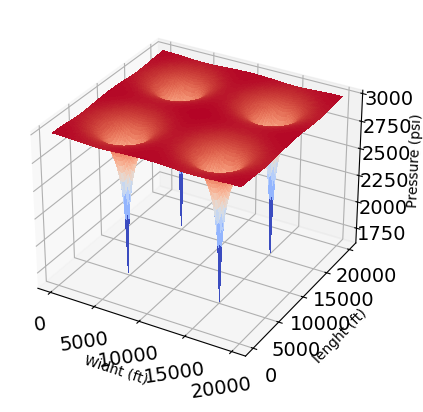

In [26]:
from matplotlib import cm, colorbar
fig = plt.figure()
ax = fig.add_subplot(111, projection= '3d')

ax.plot_surface(X.T,Y.T, P_time_50, rstride= 1, cstride = 1, cmap= cm.coolwarm, linewidth= 0, antialiased= False)

ax.set_xlabel('Widht (ft)')
ax.set_ylabel('lenght (ft)')
ax.set_zlabel('Pressure (psi)')
plt.tick_params(axis= 'both', labelsize= 14)
plt.xticks(rotation= 8)
plt.tight_layout()
plt.show()
